In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet
import emsim_utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

from unet import UNet

## Write events to a DataFrame

In [13]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [27]:
# Read a new dataset.
df = emsim_utils.read_electron_data(datfile,nevts=200005)
df.to_pickle("EM_4um_back_10M_300keV_TEST.pkl")

# Generate random multi-electron events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

In [ ]:
frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

In [ ]:
frame,label = frameset[0]
logscale = False

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Frame (log counts)")
else:
    plt.imshow(frame) #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Frame")

ax2 = fig.add_subplot(122);
plt.imshow(label)
plt.title("Truth")

## Train a network (multi-electron)

In [2]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-4   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_frames_50x50_noise20_163.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=22,nelec_sigma=0.5,noise_mean=0,noise_sigma=20)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=8)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if model.n_classes > 1 else 'max', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 100000


In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train_unet(model, epoch, train_loader, optimizer)

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_50x50_noise20_{}.pt".format(modeldir,epoch))

#### Test the net

In [29]:
sigmoid = nn.Sigmoid()
dset_test = tr.EMDataset("dataframes/EM_4um_back_10M_300keV_TEST.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0,nstart=100005)
dataset_test = tr.EMFrameDataset(dset_test,frame_size=50,nelec_mean=22,nelec_sigma=0.5,noise_mean=0,noise_sigma=20)
model.eval()

Created dataset for events from 100005 to 99991


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.

20/21 electrons predicted
12/21 electrons coincided exactly
2471/2479 empty spaces coincided exactly


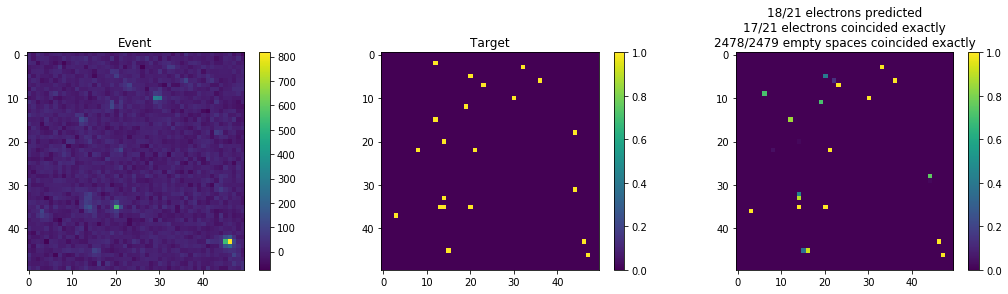

In [89]:
evt_plt = 100001
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

# Determine number of correct pixels
th = 0.1
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

In [31]:
evt_lbl

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
prob

array([[-19.005571, -18.069258, -19.140171, ..., -19.19761 , -20.92552 ,
        -17.105713],
       [-17.558983, -18.519545, -17.440496, ..., -17.539255, -14.447085,
        -18.231619],
       [-16.867271, -17.019657, -16.726553, ..., -16.585522, -17.25026 ,
        -17.057737],
       ...,
       [-17.562973, -18.034128, -19.02564 , ..., -16.861391, -16.49287 ,
        -16.464968],
       [-17.76257 , -16.742579, -21.656904, ..., -16.228807, -17.078026,
        -17.494265],
       [-26.054821, -14.131465, -15.069647, ..., -15.184809, -15.919353,
        -16.096058]], dtype=float32)

## Train a network (single-electrons)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-4   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 74      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_10cells_noise_100k_74.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        tr.val(model, epoch, val_loader)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_10cells_noise_100k_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

Text(0.5, 1.0, 'Accuracy')

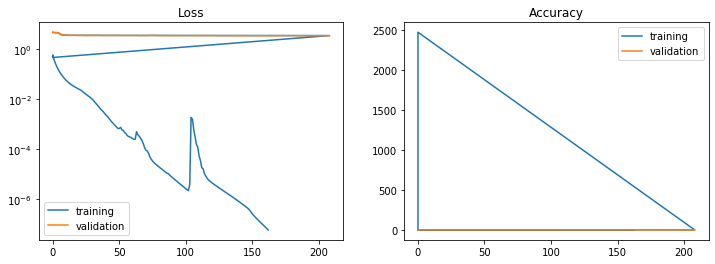

In [71]:
# Plot the training and validation losses.
tloss = np.loadtxt("train.txt")
vloss = np.loadtxt("val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(80000,80100)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.02
sigma_cut = 1e9
plt.hist(df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN,alpha=0.8,bins=50,color='blue',label='NN error')
plt.hist(df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3,alpha=0.8,bins=50,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
plt.yscale('log')
plt.legend()

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 81001
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX + dset.add_shift*emnet.PIXEL_SIZE
ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))